# 0. Environment

## 0-1. check and install

In [1]:
!python --version

Python 3.6.9


In [2]:
import tensorflow as tf
print('tensorflow version:', tf.__version__)

tensorflow version: 2.4.3


In [3]:
import random

In [4]:
#!apt update
#!apt install wget
#!apt install libsndfile1-dev -y

In [5]:
#!python -m pip install --upgrade pip 
#!python -m pip install librosa
#!python -m pip install python_speech_features
!python -m pip install seaborn

## 0-2. set parameter

In [6]:
dataset_path = './data_speech_commands_v002'

In [7]:
import numpy as np
commands = np.array(['yes','no','on','off'])

# 1. Prepare dataset

## 1-1. get dataset

In [8]:
import os
if not os.path.exists(dataset_path):
    if not os.path.isfile('speech_commands_v0.02.tar.gz') :
        !wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
    !mkdir data_speech_commands_v002
    !tar zxvf "./speech_commands_v0.02.tar.gz" --directory data_speech_commands_v002

## 2-2. dataset details

In [9]:
dataset_dirslist = np.array(tf.io.gfile.listdir(str(dataset_path)))
print ('dataset_dirslist:', dataset_dirslist,', num: ' , len(dataset_dirslist))
print('-')

dataset_commands_dirslist = dataset_dirslist
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != 'README.md']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != '.DS_Store']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != 'validation_list.txt']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != 'testing_list.txt']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != 'LICENSE']
dataset_commands_dirslist = dataset_commands_dirslist[dataset_commands_dirslist != '_background_noise_']
print ('dataset_commands_dirslist:', dataset_commands_dirslist,', num: ' , len(dataset_commands_dirslist))

dataset_dirslist: ['on' 'right' 'tree' 'house' 'dog' 'marvin' 'visual' 'one' 'off' 'bed'
 'wow' 'eight' 'down' 'seven' 'left' 'up' 'follow' 'zero' 'four' 'three'
 'forward' 'five' '.DS_Store' 'stop' 'two' 'no' 'README.md'
 'testing_list.txt' 'happy' 'LICENSE' '_background_noise_'
 'validation_list.txt' 'yes' 'go' 'bird' 'cat' 'backward' 'learn' 'sheila'
 'nine' 'six'] , num:  41
-
dataset_commands_dirslist: ['on' 'right' 'tree' 'house' 'dog' 'marvin' 'visual' 'one' 'off' 'bed'
 'wow' 'eight' 'down' 'seven' 'left' 'up' 'follow' 'zero' 'four' 'three'
 'forward' 'five' 'stop' 'two' 'no' 'happy' 'yes' 'go' 'bird' 'cat'
 'backward' 'learn' 'sheila' 'nine' 'six'] , num:  35


## 2-3. dataset commands filepaths

In [10]:
dataset_commands_filepaths = []
for item in dataset_commands_dirslist:
    dataset_commands_dir = os.path.join(dataset_path, item,'*')
    print('dataset_commands_dir:', dataset_commands_dir)
    fileslist = tf.io.gfile.glob(dataset_commands_dir)
    print('file num of',item,':', len(fileslist))
    dataset_commands_filepaths.extend(fileslist)
    print('-')
print('num of dataset_commands_filepaths:', len(dataset_commands_dirslist))
print('num of dataset_commands_filepaths:', len(dataset_commands_filepaths))
print('sample of dataset_commands_filepaths:', dataset_commands_filepaths[0])

dataset_commands_dir: ./data_speech_commands_v002/on/*
file num of on : 3845
-
dataset_commands_dir: ./data_speech_commands_v002/right/*
file num of right : 3778
-
dataset_commands_dir: ./data_speech_commands_v002/tree/*
file num of tree : 1759
-
dataset_commands_dir: ./data_speech_commands_v002/house/*
file num of house : 2113
-
dataset_commands_dir: ./data_speech_commands_v002/dog/*
file num of dog : 2128
-
dataset_commands_dir: ./data_speech_commands_v002/marvin/*
file num of marvin : 2100
-
dataset_commands_dir: ./data_speech_commands_v002/visual/*
file num of visual : 1592
-
dataset_commands_dir: ./data_speech_commands_v002/one/*
file num of one : 3890
-
dataset_commands_dir: ./data_speech_commands_v002/off/*
file num of off : 3745
-
dataset_commands_dir: ./data_speech_commands_v002/bed/*
file num of bed : 2014
-
dataset_commands_dir: ./data_speech_commands_v002/wow/*
file num of wow : 2123
-
dataset_commands_dir: ./data_speech_commands_v002/eight/*
file num of eight : 3787
-
data

# 2. Audio Preporcess

## 2-1. function

### 2-1-1. split num

In [11]:
def get_split_num(train_ratio = 0.8, val_ratio = 0.1, test_ratio = 0.1, file_num = 0):
    #get train , val, test num
    train_num = int( file_num * train_ratio )
    val_num = int( file_num * val_ratio )
    test_num = file_num - train_num - val_num 

    #get train , val, test first_num
    train_first_num = 0
    val_first_num = train_num
    test_first_num = train_num + val_num
    
    return train_first_num, val_first_num, test_first_num

### 2-1-2. label

In [12]:
def get_label(filepath):
    split_1=os.path.split(filepath)
    split_2=os.path.split(split_1[0])
    return split_2[1]
tmp = get_label(dataset_commands_filepaths[0])
print ('get_label(dataset_commands_filepaths[0]):')
print (type(tmp))
print (tmp)

get_label(dataset_commands_filepaths[0]):
<class 'str'>
on


### 2-1-3. waveform

In [13]:
import librosa
def get_waveform(filepath):
    sample_rate = 16000
    waveform, fs = librosa.load(filepath, sr=sample_rate)
    return waveform
tmp = get_waveform(dataset_commands_filepaths[0])
print ('get_waveform(dataset_commands_filepaths[0]):')
print (type(tmp))
print (tmp.shape)
print (tmp)

get_waveform(dataset_commands_filepaths[0]):
<class 'numpy.ndarray'>
(16000,)
[0.00115967 0.00131226 0.00119019 ... 0.0015564  0.00164795 0.00143433]


### 2-1-4. label id

In [14]:
def get_label_id(label,command_list):
    label_id = np.argmax(label==command_list)
    return label_id
tmp = get_label_id(get_label(dataset_commands_filepaths[0]),dataset_commands_dirslist)
print ('get_label_id(get_label(dataset_commands_filepaths[0]):')
print (type(tmp))
print (tmp)

get_label_id(get_label(dataset_commands_filepaths[0]):
<class 'numpy.int64'>
0


### 2-1-5-1. MFCC-python_speech_features

In [15]:
import python_speech_features
import matplotlib.pyplot as plt
def get_features_m(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    #input_len = 16000
    #waveform = waveform[:input_len]
    # np.shape(waveform) =  (16000,)
    zero_padding = np.zeros( (16000-np.shape(waveform)[0],), dtype=np.float32)
    # Cast the waveform tensors with np.float32
    waveform = np.cast['float32'](waveform)
    # Concatenate the waveform with `zero_padding`, which ensures all audio clips are of the same length.
    equal_length = np.concatenate([waveform, zero_padding], 0)
    
    sample_rate = 16000
    num_mfcc = 16
    len_mfcc = 40
    mfccs = python_speech_features.base.mfcc(equal_length, 
                                            samplerate=sample_rate,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

get_features_m(get_waveform(dataset_commands_files[0])):
type: <class 'numpy.ndarray'>
shape: (16, 16)


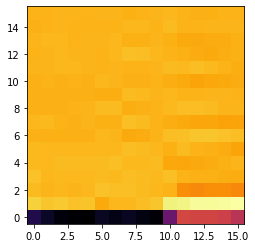

In [16]:
tmp = get_features_m(get_waveform(dataset_commands_filepaths[0]))
print ('get_features_m(get_waveform(dataset_commands_files[0])):')
print ('type:',type(tmp))
print ('shape:',tmp.shape)
#print (tmp)
fig = plt.figure()
plt.imshow(tmp, cmap='inferno', origin='lower')

### 2-1-5-1. MFCC-librosa

In [17]:
import matplotlib.pyplot as plt
def get_features(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    #input_len = 16000
    #waveform = waveform[:input_len]
    # np.shape(waveform) =  (16000,)
    zero_padding = np.zeros( (16000-np.shape(waveform)[0],), dtype=np.float32)
    # Cast the waveform tensors with np.float32
    waveform = np.cast['float32'](waveform)
    # Concatenate the waveform with `zero_padding`, which ensures all audio clips are of the same length.
    equal_length = np.concatenate([waveform, zero_padding], 0)
    
    sample_rate = 16000
    num_mfcc = 16
    len_mfcc = 40
    mfccs = librosa.feature.mfcc(y=equal_length, sr=sample_rate, n_mfcc=num_mfcc)
    return mfccs

get_features(get_waveform(dataset_commands_files[0])):
type: <class 'numpy.ndarray'>
shape: (16, 32)


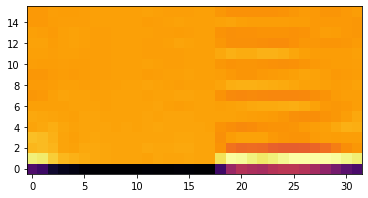

In [18]:
tmp = get_features(get_waveform(dataset_commands_filepaths[0]))
print ('get_features(get_waveform(dataset_commands_files[0])):')
print ('type:',type(tmp))
print ('shape:',tmp.shape)
#print (tmp)
fig = plt.figure()
plt.imshow(tmp, cmap='inferno', origin='lower')

### 2-1-6. Spectrum(optional)

In [19]:
import matplotlib.pyplot as plt
def get_features_s(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    #input_len = 16000
    #waveform = waveform[:input_len]
    # np.shape(waveform) =  (16000,)
    zero_padding = np.zeros( (16000-np.shape(waveform)[0],), dtype=np.float32)
    # Cast the waveform tensors with np.float32
    waveform = np.cast['float32'](waveform)
    # Concatenate the waveform with `zero_padding`, which ensures all audio clips are of the same length.
    equal_length = np.concatenate([waveform, zero_padding], 0)
    
    sample_rate = 16000
    spectrum = np.abs(librosa.stft(equal_length, n_fft=512))
    return spectrum.transpose()

get_features_s(get_waveform(dataset_commands_files[5000])):
type: <class 'numpy.ndarray'>
shape: (126, 257)


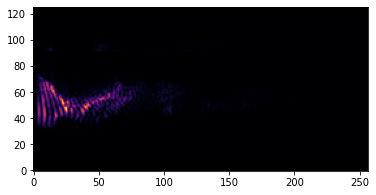

In [20]:
tmp = get_features_s(get_waveform(dataset_commands_filepaths[5000]))
print ('get_features_s(get_waveform(dataset_commands_files[5000])):')
print ('type:',type(tmp))
print ('shape:',tmp.shape)
#print (tmp)
fig = plt.figure()
plt.imshow(tmp, cmap='inferno', origin='lower')

## 2-2. Preporcess set commands

In [21]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

### 2-2-1. get set command filepaths

In [22]:
train_set_commands_filepaths = []
val_set_commands_filepaths = []
test_set_commands_filepaths = []
set_commands_dirslist = commands
for item in set_commands_dirslist:
    set_commands_dir = os.path.join(dataset_path, item,'*')
    print('set_commands_dir:', set_commands_dir)
    
    fileslist = tf.io.gfile.glob(set_commands_dir)
    random.shuffle(fileslist)
    print('file num :', len(fileslist))
    
    train, val, test = get_split_num(0.8, 0.1, 0.1, len(fileslist))
    train_set_commands_filepaths.extend(fileslist[:val])
    val_set_commands_filepaths.extend(fileslist[val:test])
    test_set_commands_filepaths.extend(fileslist[test:])
    
    print('-')
print('num of train_set_commands_filepaths:', len(train_set_commands_filepaths))
print('num of val_set_commands_filepaths:', len(val_set_commands_filepaths))
print('num of test_set_commands_filepaths:', len(test_set_commands_filepaths))
total_set_commands_num = len(train_set_commands_filepaths)+len(val_set_commands_filepaths)+len(test_set_commands_filepaths)
print('total of set_commands_filepaths:',total_set_commands_num)
print('sample of train_set_commands_filepaths:', train_set_commands_filepaths[0])


set_commands_dir: ./data_speech_commands_v002/yes/*
file num : 4044
-
set_commands_dir: ./data_speech_commands_v002/no/*
file num : 3941
-
set_commands_dir: ./data_speech_commands_v002/on/*
file num : 3845
-
set_commands_dir: ./data_speech_commands_v002/off/*
file num : 3745
-
num of train_set_commands_filepaths: 12459
num of val_set_commands_filepaths: 1556
num of test_set_commands_filepaths: 1560
total of set_commands_filepaths: 15575
sample of train_set_commands_filepaths: ./data_speech_commands_v002/yes/3a69f765_nohash_4.wav


### 2-2-2. get features and label id

In [23]:
train_set_commands_features = []
val_set_commands_features = []
test_set_commands_features = []

train_set_commands_label_id = []
val_set_commands_label_id = []
test_set_commands_label_id = []

for i, item in enumerate(train_set_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    train_set_commands_features.append(features)

    label = get_label(item)
    label_id = get_label_id(label,commands)
    train_set_commands_label_id.append(label_id)

for i, item in enumerate(val_set_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    val_set_commands_features.append(features)

    label = get_label(item)
    label_id = get_label_id(label,commands)
    val_set_commands_label_id.append(label_id)
        
for i, item in enumerate(test_set_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    test_set_commands_features.append(features)

    label = get_label(item)
    label_id = get_label_id(label,commands)
    test_set_commands_label_id.append(label_id)        
        

print ('num of train_set_commands_features:', len(train_set_commands_features))
print ('num of train_set_commands_label_id:', len(train_set_commands_label_id))
print('-')
print ('num of val_set_commands_features:', len(val_set_commands_features))
print ('num of val_set_commands_label_id:', len(val_set_commands_label_id))
print('-')
print ('num of test_set_commands_features:', len(test_set_commands_features))
print ('num of test_set_commands_label_id:', len(test_set_commands_label_id)) 

num of train_set_commands_features: 12459
num of train_set_commands_label_id: 12459
-
num of val_set_commands_features: 1556
num of val_set_commands_label_id: 1556
-
num of test_set_commands_features: 1560
num of test_set_commands_label_id: 1560


### 2-2-3. add features and label id to dataset

In [24]:
x_train.extend(train_set_commands_features)
y_train.extend(train_set_commands_label_id)
x_val.extend(val_set_commands_features)
y_val.extend(val_set_commands_label_id)
x_test.extend(test_set_commands_features)
y_test.extend(test_set_commands_label_id)

print('num of x_train:',len(y_train))
print('num of y_train:',len(y_train))
print('-')
print('num of x_val:',len(x_val))
print('num of y_val:',len(y_val))
print('-')
print('num of x_test:',len(x_test))
print('num of y_test:',len(y_test))

num of x_train: 12459
num of y_train: 12459
-
num of x_val: 1556
num of y_val: 1556
-
num of x_test: 1560
num of y_test: 1560


## 2-3. Preporcess unknown commands

### 2-3-1. get unknown command filepaths

In [25]:
train_unknown_commands_filepaths = []
val_unknown_commands_filepaths = []
test_unknown_commands_filepaths = []

if not np.any(commands=='unknown'):
    commands = np.append(commands,'unknown')
print ('commands:',commands)
print('-')

unknown_commands_dirslist = np.setdiff1d( dataset_commands_dirslist , commands)
print ('unknown_commands_dirslist:',unknown_commands_dirslist)
print('-')

print ('total_set_commands_num:', total_set_commands_num)
unknown_ratio = 0.2
print('unknown_ratio:',unknown_ratio)
unknown_command_num = int(total_set_commands_num * unknown_ratio)
print ('unknown_command_num:', unknown_command_num)
each_unknown_command_num = unknown_command_num//len(unknown_commands_dirslist)
print ('each_unknown_command_num:', each_unknown_command_num)
print('-')

for item in unknown_commands_dirslist:
    unknown_commands_dir = os.path.join(dataset_path, item,'*')
    print('unknown_commands_dir:', unknown_commands_dir)
    
    fileslist = tf.io.gfile.glob(unknown_commands_dir)
    random.shuffle(fileslist)
    print('file num :', len(fileslist))
    
    train, val, test = get_split_num(0.8, 0.1, 0.1, each_unknown_command_num)
    train_unknown_commands_filepaths.extend(fileslist[:val])
    val_unknown_commands_filepaths.extend(fileslist[val:test])
    test_unknown_commands_filepaths.extend(fileslist[test:each_unknown_command_num])
    print('-')
    
print('num of train_unknown_commands_filepaths:', len(train_unknown_commands_filepaths))
print('num of val_unknown_commands_filepaths:', len(val_unknown_commands_filepaths))
print('num of test_unknown_commands_filepaths:', len(test_unknown_commands_filepaths))
print('sample of train_unknown_commands_filepaths:', train_unknown_commands_filepaths[0])

commands: ['yes' 'no' 'on' 'off' 'unknown']
-
unknown_commands_dirslist: ['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine'
 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up'
 'visual' 'wow' 'zero']
-
total_set_commands_num: 15575
unknown_ratio: 0.2
unknown_command_num: 3115
each_unknown_command_num: 100
-
unknown_commands_dir: ./data_speech_commands_v002/backward/*
file num : 1664
-
unknown_commands_dir: ./data_speech_commands_v002/bed/*
file num : 2014
-
unknown_commands_dir: ./data_speech_commands_v002/bird/*
file num : 2064
-
unknown_commands_dir: ./data_speech_commands_v002/cat/*
file num : 2031
-
unknown_commands_dir: ./data_speech_commands_v002/dog/*
file num : 2128
-
unknown_commands_dir: ./data_speech_commands_v002/down/*
file num : 3917
-
unknown_commands_dir: ./data_speech_commands_v002/eight/*
file num : 3787
-
unknown_commands_dir: ./data_speech_commands_v002/five/*
f

### 2-3-2. get features and label id

In [26]:
train_unknown_commands_features = []
val_unknown_commands_features = []
test_unknown_commands_features = []

train_unknown_commands_label_id = []
val_unknown_commands_label_id = []
test_unknown_commands_label_id = []

label = 'unknown'
label_id = get_label_id(label,commands)

for i, item in enumerate(train_unknown_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    train_unknown_commands_features.append(features)
    train_unknown_commands_label_id.append(label_id)

for i, item in enumerate(val_unknown_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    val_unknown_commands_features.append(features)
    val_unknown_commands_label_id.append(label_id)
        
for i, item in enumerate(test_unknown_commands_filepaths):
    waveform = get_waveform(item)
    features = get_features(waveform)
    test_unknown_commands_features.append(features)
    test_unknown_commands_label_id.append(label_id)        
        

print ('num of train_unknown_commands_features:', len(train_unknown_commands_features))
print ('num of train_unknown_commands_label_id:', len(train_unknown_commands_label_id))
print('-')
print ('num of val_unknown_commands_features:', len(val_unknown_commands_features))
print ('num of val_unknown_commands_label_id:', len(val_unknown_commands_label_id))
print('-')
print ('num of test_unknown_commands_features:', len(test_unknown_commands_features))
print ('num of test_unknown_commands_label_id:', len(test_unknown_commands_label_id)) 

num of train_unknown_commands_features: 2480
num of train_unknown_commands_label_id: 2480
-
num of val_unknown_commands_features: 310
num of val_unknown_commands_label_id: 310
-
num of test_unknown_commands_features: 310
num of test_unknown_commands_label_id: 310


### 2-3-3. add features and label id to dataset

In [27]:
x_train.extend(train_unknown_commands_features)
y_train.extend(train_unknown_commands_label_id)
x_val.extend(val_unknown_commands_features)
y_val.extend(val_unknown_commands_label_id)
x_test.extend(test_unknown_commands_features)
y_test.extend(test_unknown_commands_label_id)

print('num of x_train:',len(x_train))
print('num of y_train:',len(y_train))
print('-')
print('num of x_val:',len(x_val))
print('num of y_val:',len(y_val))
print('-')
print('num of x_test:',len(x_test))
print('num of y_test:',len(y_test))

num of x_train: 14939
num of y_train: 14939
-
num of x_val: 1866
num of y_val: 1866
-
num of x_test: 1870
num of y_test: 1870


## 2-4. Preporcess slience command

### 2-4-1. get background command filepaths

In [28]:
train_slience_commands_filepaths = []
val_slience_commands_filepaths = []
test_slience_commands_filepaths = []

if not np.any(commands=='slience'):
    commands = np.append(commands,'slience')
print ('commands:',commands)
print('-')

slience_commands_dirslist = ['_background_noise_']
print ('slience_commands_dirslist:',slience_commands_dirslist)
print('-')

print ('total_set_commands_num:', total_set_commands_num)
slience_ratio = 0.2
print('slience_ratio:',slience_ratio)
slience_command_num = int(total_set_commands_num * slience_ratio)
print ('slience_command_num:', slience_command_num)
print('-')

for item in slience_commands_dirslist:
    slience_commands_dir = os.path.join(dataset_path, item,'*.wav')
    print('slience_commands_dir:', slience_commands_dir)
    
    fileslist = tf.io.gfile.glob(slience_commands_dir)
    print('file num :', len(fileslist))
    
    each_slience_files = slience_command_num//len(fileslist)
    print ('each_slience_files:', each_slience_files)
  
    train_num = int(each_slience_files*0.8)
    val_num = int(each_slience_files*0.1)
    test_num = int(each_slience_files*0.1)
    print('-')
    
    for itme in fileslist:
        for i in range(train_num):
            train_slience_commands_filepaths.append(itme)
        for i in range(val_num):
            val_slience_commands_filepaths.append(itme)
        for i in range(test_num):
            test_slience_commands_filepaths.append(itme)

print('num of train_slience_commands_filepaths:', len(train_slience_commands_filepaths))
print('num of val_slience_commands_filepaths:', len(val_slience_commands_filepaths))
print('num of test_slience_commands_filepaths:', len(test_slience_commands_filepaths))
print('sample of train_slience_commands_filepaths:', train_slience_commands_filepaths[0])

commands: ['yes' 'no' 'on' 'off' 'unknown' 'slience']
-
slience_commands_dirslist: ['_background_noise_']
-
total_set_commands_num: 15575
slience_ratio: 0.2
slience_command_num: 3115
-
slience_commands_dir: ./data_speech_commands_v002/_background_noise_/*.wav
file num : 6
each_slience_files: 519
-
num of train_slience_commands_filepaths: 2490
num of val_slience_commands_filepaths: 306
num of test_slience_commands_filepaths: 306
sample of train_slience_commands_filepaths: ./data_speech_commands_v002/_background_noise_/running_tap.wav


### 2-4-2. contruct slience features and label id

In [29]:
def get_random_background_noise_waveform(filepath):
    waveform = get_waveform(filepath)
    waveform_len = waveform.shape[0]
    waveform_s = waveform_len/16000

    split_start_time = random.randrange(0, waveform_len)
    waveform_split = waveform[split_start_time:split_start_time+16000]
    waveform_split_len = waveform_split.shape[0]
    waveform_split_s = waveform_split_len/16000

    return waveform_split

In [30]:
def get_zero_waveform():
    zero_waveform = np.zeros((16000,), dtype=np.float32)
    return zero_waveform

In [31]:
import random
random.seed(66)

train_slience_commands_features = []
val_slience_commands_features = []
test_slience_commands_features = []

train_slience_commands_label_id = []
val_slience_commands_label_id = []
test_slience_commands_label_id = []

label = 'slience'
label_id = get_label_id(label,commands)

for i, item in enumerate(train_slience_commands_filepaths):
    background_noise_waveform = get_random_background_noise_waveform(item)
    features = get_features(background_noise_waveform)
    train_slience_commands_features.append(features)
    train_slience_commands_label_id.append(label_id)
zero_waveform = get_zero_waveform()
features = get_features(zero_waveform)
train_slience_commands_features.append(features)
train_slience_commands_label_id.append(label_id)

for i, item in enumerate(val_slience_commands_filepaths):
    background_noise_waveform = get_random_background_noise_waveform(item)
    features = get_features(background_noise_waveform)
    val_slience_commands_features.append(features)
    val_slience_commands_label_id.append(label_id)    
zero_waveform = get_zero_waveform()
features = get_features(zero_waveform)
val_slience_commands_features.append(features)
val_slience_commands_label_id.append(label_id)
    
for i, item in enumerate(test_slience_commands_filepaths):
    background_noise_waveform = get_random_background_noise_waveform(item)
    features = get_features(background_noise_waveform)
    test_slience_commands_features.append(features)
    test_slience_commands_label_id.append(label_id)    
zero_waveform = get_zero_waveform()
features = get_features(zero_waveform)
test_slience_commands_features.append(features)
test_slience_commands_label_id.append(label_id)

print ('num of train_slience_commands_features:', len(train_slience_commands_features))
print ('num of train_slience_commands_label_id:', len(train_slience_commands_label_id))
print('-')
print ('num of val_slience_commands_features:', len(val_slience_commands_features))
print ('num of val_slience_commands_label_id:', len(val_slience_commands_label_id))
print('-')
print ('num of test_slience_commands_features:', len(test_slience_commands_features))
print ('num of test_slience_commands_label_id:', len(test_slience_commands_label_id)) 

num of train_slience_commands_features: 2491
num of train_slience_commands_label_id: 2491
-
num of val_slience_commands_features: 307
num of val_slience_commands_label_id: 307
-
num of test_slience_commands_features: 307
num of test_slience_commands_label_id: 307


### 2-4-3. add features and label id to dataset

In [32]:
x_train.extend(train_slience_commands_features)
y_train.extend(train_slience_commands_label_id)
x_val.extend(val_slience_commands_features)
y_val.extend(val_slience_commands_label_id)
x_test.extend(test_slience_commands_features)
y_test.extend(test_slience_commands_label_id)

print('num of x_train:',len(x_train))
print('num of y_train:',len(y_train))
print('-')
print('num of x_val:',len(x_val))
print('num of y_val:',len(y_val))
print('-')
print('num of x_test:',len(x_test))
print('num of y_test:',len(y_test))

num of x_train: 17430
num of y_train: 17430
-
num of x_val: 2173
num of y_val: 2173
-
num of x_test: 2177
num of y_test: 2177


## 2-5.  save and load processed dataset

In [33]:
''''''
feature_sets_file = 'all_targets_mfcc_sets.npz'
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)
''''''

''

In [34]:
''''''
feature_sets_path = './'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
# Load feature sets
feature_sets = np.load(os.path.join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']
''''''

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


''

# 3. Train

## 3-1. prepare input

In [35]:
train_list = list(zip(x_train, y_train))
random.shuffle(train_list)
x_train, y_train = zip(*train_list)

val_list = list(zip(x_val, y_val))
random.shuffle(val_list)
x_val, y_val = zip(*val_list)

test_list = list(zip(x_test, y_test))
random.shuffle(test_list)
x_test, y_test = zip(*test_list)

x_tn = np.array(x_train)
y_tn = np.array(y_train)
x_v = np.array(x_val)
y_v = np.array(y_val)
x_ts = np.array(x_test)
y_ts = np.array(y_test)

x_tn = np.expand_dims(x_tn, axis=-1)
x_v = np.expand_dims(x_v, axis=-1)
x_ts = np.expand_dims(x_ts, axis=-1)

print (x_tn.shape)
print (y_tn.shape)
print (x_v.shape)
print (y_v.shape)
print (x_ts.shape)
print (y_ts.shape)



(17430, 16, 32, 1)
(17430,)
(2173, 16, 32, 1)
(2173,)
(2177, 16, 32, 1)
(2177,)


## 3-2. set parameter

In [36]:
tmp = get_features(get_waveform(dataset_commands_filepaths[0]))
tmp = np.expand_dims(tmp, axis=-1)
input_shape = tmp.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (16, 32, 1)


## 3-3. build model

In [37]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 28, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 26, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 13, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 13, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4160)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## 3-4. train

In [39]:
EPOCHS = 500
history = model.fit(
    x_tn,y_tn,
    validation_data=(x_v,y_v),
    epochs=EPOCHS,
    batch_size=5,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/500
3486/3486 [==============================] - 18s 5ms/step - loss: 0.9581 - accuracy: 0.7050 - val_loss: 0.3415 - val_accuracy: 0.8748
Epoch 2/500
3486/3486 [==============================] - 17s 5ms/step - loss: 0.3019 - accuracy: 0.8934 - val_loss: 0.2910 - val_accuracy: 0.8932
Epoch 3/500
3486/3486 [==============================] - 17s 5ms/step - loss: 0.2327 - accuracy: 0.9193 - val_loss: 0.2489 - val_accuracy: 0.9121
Epoch 4/500
3486/3486 [==============================] - 17s 5ms/step - loss: 0.2040 - accuracy: 0.9299 - val_loss: 0.2853 - val_accuracy: 0.9162
Epoch 5/500
3486/3486 [==============================] - 18s 5ms/step - loss: 0.1783 - accuracy: 0.9383 - val_loss: 0.3151 - val_accuracy: 0.9213
Epoch 6/500
3486/3486 [==============================] - 18s 5ms/step - loss: 0.1696 - accuracy: 0.9467 - val_loss: 0.2837 - val_accuracy: 0.9218
Epoch 00006: early stopping


## 3-5. result

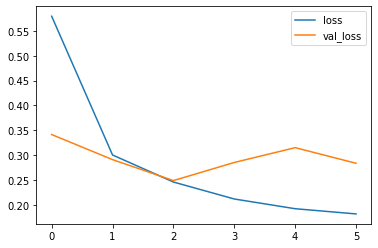

In [40]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## 3-6. save trained model

In [41]:
model_filename = 'SpeechCommandRecognition_model.h5'
# Save the model as a file
models.save_model(model, model_filename)

## 3-7. evaluate (inference on test set)

In [42]:
y_pred = np.argmax(model.predict(x_ts), axis=1)
#print(y_pred)
y_true = y_ts
#print (y_true)
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


## 3-8. display a confusion matrix

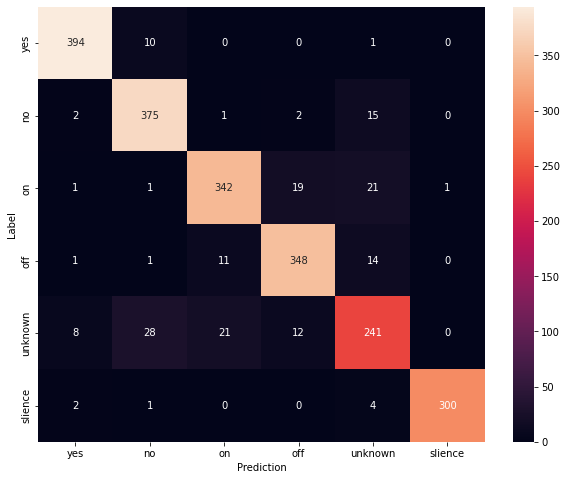

In [43]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## 3-9. run inference on an audio file

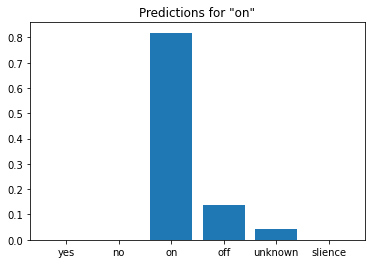

In [44]:
audio_file = os.path.join(dataset_path, 'on','0ba018fc_nohash_1.wav')
sample_feature = get_features(get_waveform(audio_file))
sample_feature = np.expand_dims(sample_feature, axis=-1)
sample_feature = np.expand_dims(sample_feature, axis=0)

sample_label = get_label(audio_file)
sample_label = get_label_id(sample_label, commands)

prediction = model(sample_feature)
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title(f'Predictions for "{commands[sample_label]}"')
plt.show()

# 4. Convert

## 4-1. set parameter

In [45]:
from tensorflow import lite
from tensorflow.keras import models
# Parameters
keras_model_filename = 'SpeechCommandRecognition_model.h5'
tflite_filename = 'SpeechCommandRecognition_model.tflite'

## 4-2. convert

In [46]:
# Convert model to TF Lite model
model = models.load_model(keras_model_filename)
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(tflite_filename, 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkwp03_g1/assets


INFO:tensorflow:Assets written to: /tmp/tmpkwp03_g1/assets


2248980

# dev